In [1]:
import os
import time
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
IMGWIDTH = 256
RANDOM_SEED = 888
BATCH_SIZE = 150
NUM_EPOCHS = 40
SPLITRATIO = [0.80, 0.95, 0.1]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = "cpu"

In [3]:
# Makes the code run on CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# I think it allows you PyTorch to show errors when running on GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
# Pre-processing the dataset

import cv2
import os

# Load pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

input_dir = 'D:\\Abhishek\\Spring 24\\AML\\Project\\Data\\Dataset\\Validation'
output_dir = 'D:/Abhishek/Spring 24/AML/Project/Data/Dataset/Validation_processed'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to process each image in the input directory
def process_images(input_dir, output_dir):
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        if os.path.isdir(category_path):
            output_category_path = os.path.join(output_dir, category)
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)
            for filename in os.listdir(category_path):
                if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                    # Read image from file
                    image_path = os.path.join(category_path, filename)
                    img = cv2.imread(image_path)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Detect faces in the image
                    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

                    # If no face detected, skip to next image
                    if len(faces) == 0:
                        print(f"No face detected in {filename}. Skipping...")
                        continue

                    # Crop and resize the face region
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face_resized = cv2.resize(face, (224, 224))

                    # Save cropped face image to output directory
                    output_path = os.path.join(output_category_path, f"{os.path.splitext(filename)[0]}_face.jpg")
                    cv2.imwrite(output_path, face_resized)
                    print(f"Processed {filename} and saved face to {output_path}")

# Process images in the input directory
process_images(input_dir, output_dir)

In [5]:
def calc_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100



def file_count(folder_path):
    count = 0
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        # Check if the path is a file (not a directory)
        if os.path.isfile(os.path.join(folder_path, filename)):
            count += 1
    return count



print("Real Samples: ", file_count("finaldata/real"))
print("Fake Samples: ", file_count("finaldata/fake"))

Real Samples:  10000
Fake Samples:  6309


In [6]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMGWIDTH, IMGWIDTH)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root="finaldata/", transform=img_transform)

train_idxs = torch.arange(0, int(SPLITRATIO[0] * len(dataset)))
test_idxs = torch.arange(int(SPLITRATIO[0] * len(dataset)), int(SPLITRATIO[1] * len(dataset)))
valid_idxs = torch.arange(int(SPLITRATIO[1] * len(dataset)), len(dataset)) 

print("Training Indices: ", train_idxs[0].item(), train_idxs[-1].item())
print("Test Indices: ", test_idxs[0].item(), test_idxs[-1].item())
print("Validation Indices: ", valid_idxs[0].item(), valid_idxs[-1].item())

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    sampler=torch.utils.data.SubsetRandomSampler(train_idxs),
)

test_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    sampler=torch.utils.data.SubsetRandomSampler(test_idxs))

val_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    sampler=torch.utils.data.SubsetRandomSampler(valid_idxs))

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break


Training Indices:  0 13046
Test Indices:  13047 15492
Validation Indices:  15493 16308
Image batch dimensions: torch.Size([75, 3, 256, 256])
Image label dimensions: torch.Size([75])
Class labels of 10 examples: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


In [6]:
print(len(train_loader), len(test_loader), len(val_loader))

174 33 11


In [7]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [10]:
class MesoNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.feat = nn.Sequential(
            # First Conv Layer
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, padding=1),

            # Second Conv Layer
            nn.Conv2d(8, 8, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2, padding=1),

            # Third Conv Layer
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, padding=1),

            # Fourth Conv Layer
            nn.Conv2d(16, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=4, padding=1)
        )

        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1024, 16),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        X = self.feat(X)
        return self.clf(X)




In [7]:
# Code taken & adjusted from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [12]:
class LeNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 6, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(6, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(
                16 * 64 * 64, 120
            ),  # Adjusted input size based on 256x256 input images
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [8]:
model = AlexNet(2).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# model = LeNet(2).to(DEVICE)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=10).to(DEVICE) # ResNet-34
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)

# Load the model weights from file
# model.load_state_dict(torch.load('model/alejxnet.pt'))
# optimizer.load_state_dict(torch.load('model/alexnet_optim.pt'))

In [9]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # ## FORWARD AND BACK PROP
        logits = model(features)
        loss = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad()

        loss.backward()

        # ## UPDATE MODEL PARAMETERS
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 100:
            print(
                f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
                f"| Batch {batch_idx:04d}/{len(train_loader):04d} "
                f"| Loss: {loss:.4f}"
            )

    model.eval()
    with torch.no_grad():  # save memory during inference
        train_acc = calc_accuracy(model, train_loader, device=DEVICE)
        valid_acc = calc_accuracy(model, val_loader, device=DEVICE)
        print(
            f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} "
            f"| Train: {train_acc :.2f}% "
            f"| Validation: {valid_acc :.2f}%"
        )
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

test_acc = calc_accuracy(model, test_loader, device=DEVICE)
print(f"Test accuracy {test_acc :.2f}%")

Epoch: 001/040 | Batch 0000/0174 | Loss: 0.6921
Epoch: 001/040 | Batch 0100/0174 | Loss: 0.7115
Epoch: 001/040 | Train: 55.45% | Validation: 98.28%
Time elapsed: 1.69 min
Epoch: 002/040 | Batch 0000/0174 | Loss: 0.7069
Epoch: 002/040 | Batch 0100/0174 | Loss: 0.6579
Epoch: 002/040 | Train: 64.30% | Validation: 60.17%
Time elapsed: 3.15 min
Epoch: 003/040 | Batch 0000/0174 | Loss: 0.6564
Epoch: 003/040 | Batch 0100/0174 | Loss: 0.6606
Epoch: 003/040 | Train: 68.69% | Validation: 83.58%
Time elapsed: 4.72 min
Epoch: 004/040 | Batch 0000/0174 | Loss: 0.5374
Epoch: 004/040 | Batch 0100/0174 | Loss: 0.6414
Epoch: 004/040 | Train: 69.66% | Validation: 71.57%
Time elapsed: 6.27 min
Epoch: 005/040 | Batch 0000/0174 | Loss: 0.6298
Epoch: 005/040 | Batch 0100/0174 | Loss: 0.5776
Epoch: 005/040 | Train: 70.66% | Validation: 66.54%
Time elapsed: 7.77 min
Epoch: 006/040 | Batch 0000/0174 | Loss: 0.5508
Epoch: 006/040 | Batch 0100/0174 | Loss: 0.5785
Epoch: 006/040 | Train: 72.70% | Validation: 73.0

In [15]:
# Code for saving the Model
torch.save(model.state_dict(), "model/alexnet.pt")
torch.save(optimizer.state_dict(), "model/alexnet_optim.pt")

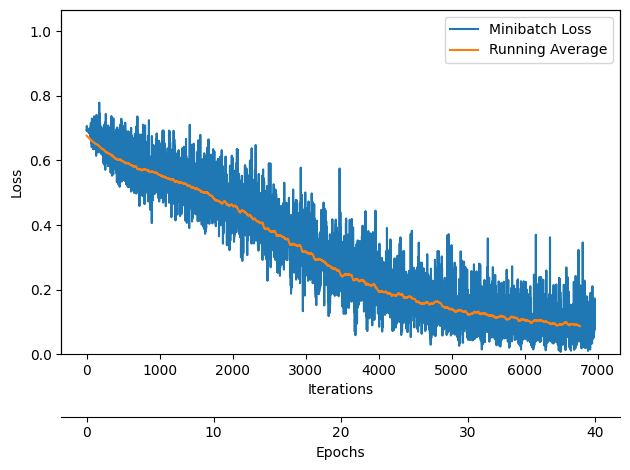

In [10]:
plt.figure()
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(minibatch_loss_list)), (minibatch_loss_list), label="Minibatch Loss")

if len(minibatch_loss_list) > 1000:
    ax1.set_ylim([0, np.max(minibatch_loss_list[1000:]) * 1.5])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax1.plot(
    np.convolve(
        minibatch_loss_list,
        np.ones(
            200,
        )
        / 200,
        mode="valid",
    ),
    label="Running Average",
)
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS + 1))

newpos = [e * len(train_loader) for e in newlabel]

ax2.set_xticks(newpos[::10])
ax2.set_xticklabels(newlabel[::10])

ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 45))
ax2.set_xlabel("Epochs")
ax2.set_xlim(ax1.get_xlim())
###################

plt.tight_layout()

# Uncomment to save the loss plot
# image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
# plt.savefig(image_path)

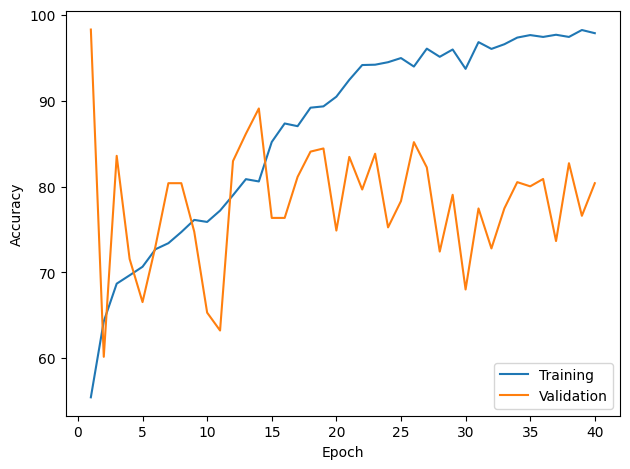

In [11]:
plt.plot(np.arange(1, NUM_EPOCHS+1),
            train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1),
            valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Uncomment to save the plot and define a result_dir
# if results_dir is not None:
#     image_path = os.path.join(
#         results_dir, 'plot_acc_training_validation.pdf')
#     plt.savefig(image_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

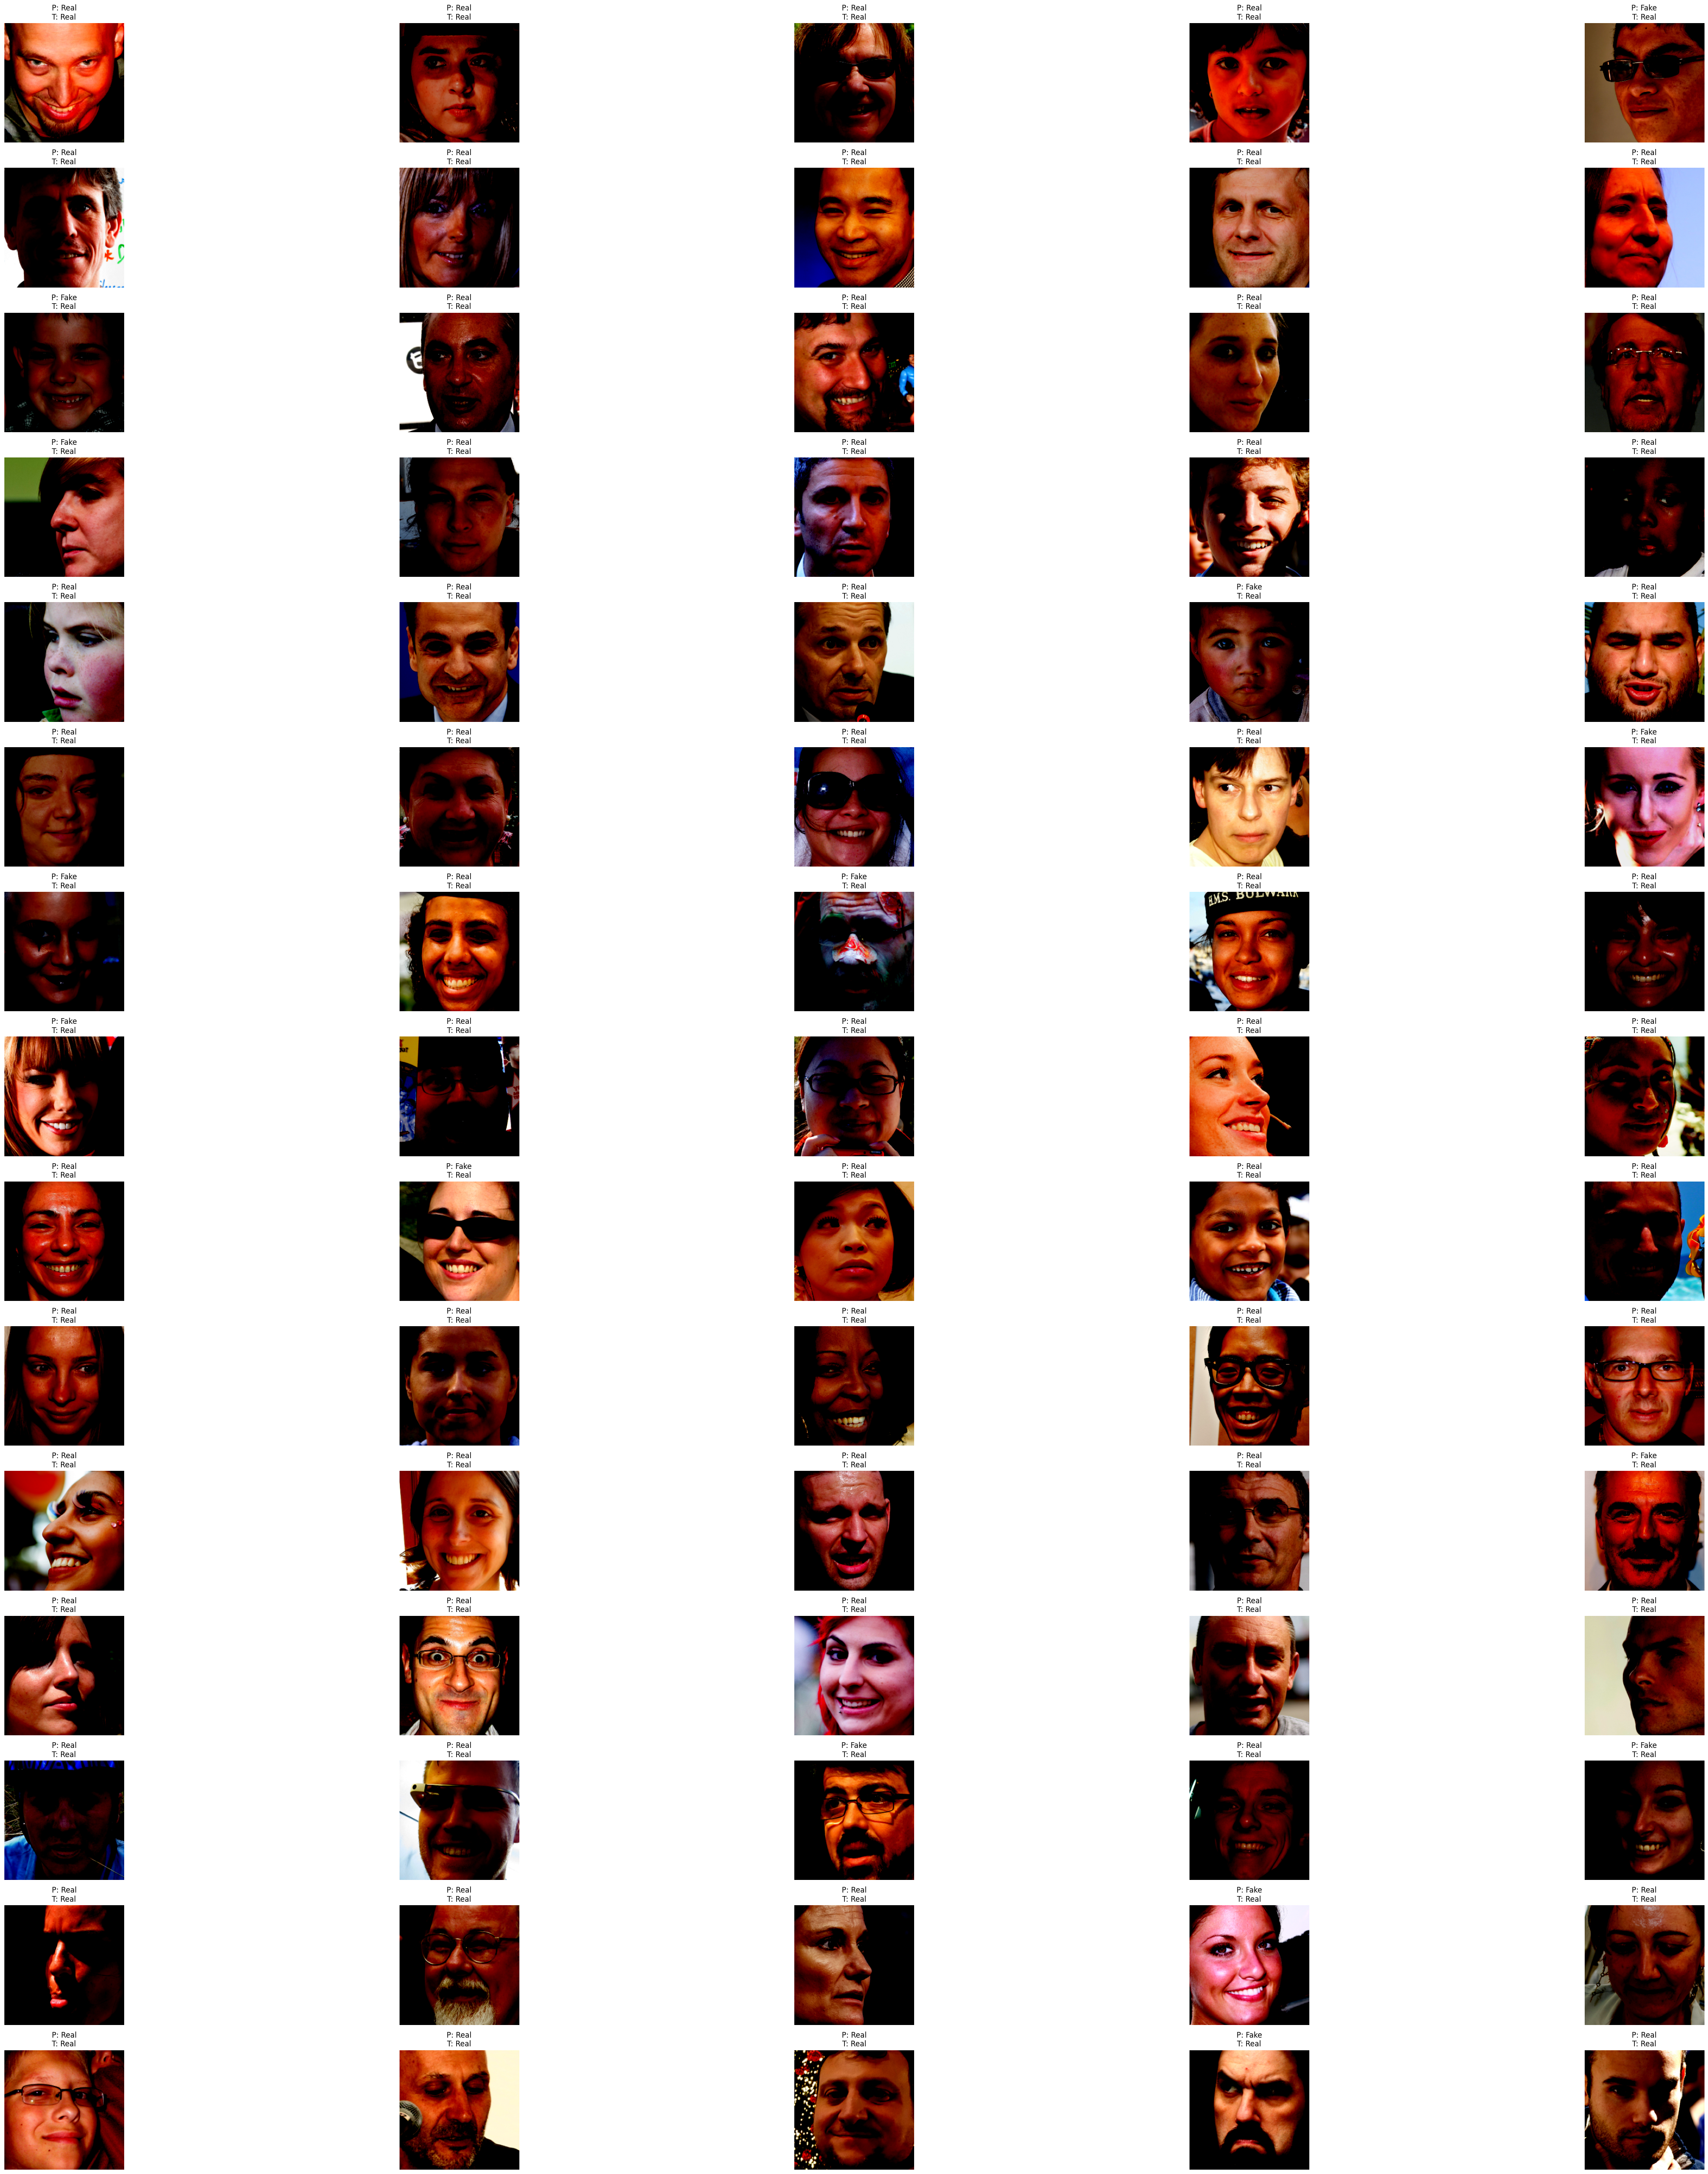

In [18]:
# Code for showing Examples of predictions
class_dict = {0: "Fake", 1: "Real"}

# Make predictions on Test Data
for batch_idx, (features, targets) in enumerate(test_loader):

    with torch.no_grad():
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        logits = model(features)
        predictions = torch.argmax(logits, dim=1)
    break

fig, axes = plt.subplots(nrows=15, ncols=5, sharex=True, sharey=True, figsize=(50, 50))

# Move the Tensors to CPU again, so the code below can run
features = features.cpu()
targets = targets.cpu()

nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))

if nhwc_img.shape[-1] == 1:
    nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap="binary")
        if class_dict is not None:
            ax.title.set_text(
                f"P: {class_dict[predictions[idx].item()]}"
                f"\nT: {class_dict[targets[idx].item()]}"
            )
        else:
            ax.title.set_text(f"P: {predictions[idx]} | T: {targets[idx]}")
        ax.axison = False

else:
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhwc_img[idx])
        if class_dict is not None:
            ax.title.set_text(
                f"P: {class_dict[predictions[idx].item()]}"
                f"\nT: {class_dict[targets[idx].item()]}"
            )
        else:
            ax.title.set_text(f"P: {predictions[idx]} | T: {targets[idx]}")
        ax.axison = False

fig.subplots_adjust()
plt.tight_layout()
plt.show()